# Neural Network Model vs. Augmented Model

Programming Language: R 4.11.0 in Jupyter Notebook

R Libraries used:
- ggplot2
- reshape2
- h2o


## Self Taught Learning

In this activity, we are going to implement a self-taught neural network using an autoencoder and a 3-layer neural network. A self-taught algorithm learns from the unlabeled data which acts as a feature representation of the input data.

Let us discuss the performance of the self-taught training for a neural network using Autoencoder. 

- An auto-encoder is an unsupervised artificial neural network that compresses and encodes the given data and can reproduce data from that encoded form. This reproduced data is as close as possible to the original data. By ignoring the noise in the data, autoencoders are well-suited for dimensionality reduction.

- One of the components of an autoencoder is the reconstruction loss or error. This error is a measure of the performance of the decoding process and the closeness of the decoded output to the original data. The reconstruction loss is measured by computing the Euclidean distance between the input and the output.

- The autoencoder adds weights to the input and optimises them as much as possible to reduce the reconstruction error.

### Self Taught Neural Network Learning

To achieve this comparative study, we will be implementing a deep learning library in R called H2O. Let us start by loading this library along with a couple of others for visualization.

In [1]:
# Specifying the required packages
packages <- c("ggplot2", "reshape2", "h2o")

# Installing the required packages if not installed
installed_packages <- packages %in% rownames(installed.packages())
if (any(installed_packages == FALSE)) {
  install.packages(packages[!installed_packages])
}

# Loading the required packages
invisible(lapply(packages, library, character.only = TRUE))

options(warn = -1)

# Setting a random seed to reproduce the outputs
set.seed(1234)


----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit https://docs.h2o.ai

----------------------------------------------------------------------



Attaching package: ‘h2o’


The following objects are masked from ‘package:stats’:

    cor, sd, var


The following objects are masked from ‘package:base’:

    &&, %*%, %in%, ||, apply, as.factor, as.numeric, colnames,
    colnames<-, ifelse, is.character, is.factor, is.numeric, log,
    log10, log1p, log2, round, signif, trunc




In [2]:
# Initialising the values for starting h2o
localH2O =  h2o.init(nthreads = -1, port = 54321, max_mem_size = '6G', strict_version_check = FALSE, startH2O = TRUE)


H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    /tmp/Rtmpb8DX4F/file2178be218b/h2o_UnknownUser_started_from_r.out
    /tmp/Rtmpb8DX4F/file2150b22fc1/h2o_UnknownUser_started_from_r.err


Starting H2O JVM and connecting: ...... Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         3 seconds 971 milliseconds 
    H2O cluster timezone:       Etc/UTC 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.36.1.2 
    H2O cluster version age:    4 months and 16 days !!! 
    H2O cluster name:           H2O_started_from_R_root_pzv484 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   6.00 GB 
    H2O cluster total cores:    4 
    H2O cluster allowed cores:  4 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    R Versio

### I. Loading the Datasets

Having initialised h2o, we can now use it to import the three datasets with the help of the h2o.import() function. Next, we will clean and combine the labeled and unlabled datasets into a single training dataset. Finally, we will define an error function to compute the test errors for the different models we are going to implement.

In [3]:
# Loading the unlabeled dataframe for training the autoencoder
unlabel.data <- h2o.importFile(path = './unlabelled.csv', sep = ',')

# Loading the labeled dataframe for training the classifier
label.data <- h2o.importFile(path = './labelled.csv', sep = ',')

# Loading the test data
test.data <- h2o.importFile(path = './test.csv', sep = ',')

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


In [4]:
# Changing the datatype of the labels in the classifier train data to factor
label.data[,1] <- as.factor(label.data$label)

# Changing the datatype of the labels in the test data to factor
test.data[,1] <- as.factor(test.data$label)

In [5]:
# Eliminating NA values from the unlabeled dataset
unlabel.data <- na.omit(unlabel.data)

# Removing the labels from the unlabeled data
unlabel.data[,1] <- NA

In [6]:
# Binding the rows of both labeled and unlabeled training data
train.data <- h2o.rbind(label.data[,-1], unlabel.data[,-1])

In [7]:
# Defining a function to calculate the test error
error.rate <- function(Y1, T1){
  if (nrow(Y1)!=nrow(T1)){
    stop('error.rate: Size of true lables & Predicted labels mismatch')
  }
  return (sum(T1!=Y1)/nrow(T1))
}

### II. Training the Autoencoder, III. Calculating and Recording the Reconstruction Error, IV. 3-layer Neural Network, V. Augmented Self-taught Network

The below function will take the combined train data, test data and the labeled data as parameters. It will compute the autoencoder reconstruction errors and the classification errors for the augmented feature model and the 3-Layer Neural network model and return the errors in a list of dataframes.

In [8]:
# Defining a function to perform a number of self taught learning models
self.taught <- function(train, test, labeled) {

  ######################### Task II. starts here ################################

  # Defining matrix constructs for storing the training errors
  reconstruction.train.error <- matrix(NA, nrow = 12, ncol=1)
  classification.labeled.error <- matrix(NA, nrow = 12, ncol=2)

  # Defining matrix constructs for storing the test errors
  reconstruction.test.error <- matrix(NA, nrow = 12, ncol=1)
  classification.test.error <- matrix(NA, nrow = 12, ncol=2)

  # Creating an empty list for storing the different error dataframes
  error.data <- list()

  # Looping through different number of neurons
  for (n in seq(30, 360, 30)){

    # Training the autoencoder model
    NN.autoencoder <- h2o.deeplearning(
            x = 2:ncol(train), # Selecting all the pixels and additional features
            training_frame = train, # Providing the training data
            hidden = c(n), # Specifying the number of hidden layers and their units
            epochs = 50, # maximum number of epoches
            activation = 'Tanh', # Specifying the activation function
            autoencoder = TRUE, # Identifying it as the autoencoder
    )

    # Calculating the index value for recording each error in the error dataframes
    index <- n/30

    ######################### Task III. starts here ################################

    # Calculating the reconstruction error for the above autoencoder model
    reconstruction.train.error[index,1] <- mean(h2o.anomaly(NN.autoencoder, train))
    reconstruction.test.error[index,1]<-mean(h2o.anomaly(NN.autoencoder, test))

    ######################### Task IV. starts here ################################

    # Training a 3-Layer NN classification model with the labeled dataframe
    NN.classifier <- h2o.deeplearning(
            x = 2:ncol(labeled), # Selecting all the pixels and additional features
            y = 1,
            training_frame = labeled, # specify the frame (imported file)
            hidden = c(n), # number of layers and their units
            epochs = 50, # maximum number of epoches
            activation = 'Tanh', # activation function
            autoencoder = FALSE, # Setting the autoencoder identifier to false
            l2 = 0.1
    )

    # Recording the classification error for training data and testing data
    labeled.predict <- h2o.predict(NN.classifier, labeled)$predict
    test.predict <- h2o.predict(NN.classifier, test)$predict

    classification.labeled.error[index,1] <- error.rate(labeled$label, labeled.predict)
    classification.test.error[index,1] <- error.rate(test$label, test.predict)

    ######################### Task V_A starts here ################################

    # Acquiring the features from middle layer of the autoencoder output
    autoencoder.features <- h2o.deepfeatures(NN.autoencoder, train, layer = 1)

    # Combining the extracted features with the original features of labeled dataframe
    augmented.data <- h2o.cbind(labeled, autoencoder.features[1:nrow(labeled),])

    ######################### Task V_B starts here ################################

    #Training the 3-Layer NN classification model with additional features
    augmented.NN.classifer <- h2o.deeplearning(
            x = 2:ncol(augmented.data), # Selecting all the pixels and additional features
            y = 1,
            training_frame = augmented.data, # specify the frame (imported file)
            hidden = c(n), # Specifying the number of layers and their units
            epochs = 50, # Setting the maximum number of epoches
            activation = 'Tanh', # Specifying the activation function
            autoencoder = FALSE, # Autoencoder property is set to False
            l2 = 0.1
    )

    # Computing the classification error for the augmented train data
    aug.labeled.predict <- h2o.predict(augmented.NN.classifer, augmented.data)$predict

    # Recording the classification error for the augmented train data
    classification.labeled.error[index,2] <- error.rate(augmented.data$label, aug.labeled.predict)

    # Computing the classification error for the test data with the augmented classifier
    aug.test.predict <- h2o.predict(augmented.NN.classifer, test)$predict

    # Recording the classification error for the test data with the augmented classifier
    classification.test.error[index,2] <- error.rate(test$label, aug.test.predict)


  }
  
  # Recording the reconstruction train error
  error.data$reconstruction.train.error <- reconstruction.train.error
  
  # Recording the classification labeled error 
  error.data$classification.labeled.error <- classification.labeled.error

  # Recording the reconstruction test error
  error.data$reconstruction.test.error <- reconstruction.test.error
  
  # Recording the classification test error 
  error.data$classification.test.error <- classification.test.error

  # Returning the list of error dataframes
  return(error.data)

}

# Calling the self taught function to return the list of computed error frames
self.taught.errors <- self.taught(train.data, test.data, label.data)

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

### VI. Plotting the Error Rates

Let us plot the errors of the above models so that we may compare their performance. We have used a different number of hidden units with the autoencoder. The goal is to select the model with a certain number of hidden units that produces the lowest error.

We can begin this process by extracting the error rates from the list.

In [9]:
# Extracting the reconstruction train error from the returned list
reconstruction.train.error <- self.taught.errors$reconstruction.train.error

# Extracting the reconstruction test error from the returned list
reconstruction.test.error <- self.taught.errors$reconstruction.test.error

# Extracting the classification labeled error from the returned list
classification.labeled.error <- self.taught.errors$classification.labeled.error

# Extracting the classification test error from the returned list
classification.test.error <- self.taught.errors$classification.test.error

Now, let us obtain the reconstruction errors for the autoencoder and the classification errors for the neural network and augmented feature model.

In [10]:
# Optional Code: Computing the reconstruction train error for the autoencoder
reconstruction.train.error <- data.frame('N' = seq(30, 360, 30), 'train.error' = reconstruction.train.error[,1])

In [11]:
# Computing the reconstruction test error for the autoencoder
reconstruction.test.error <- data.frame('N' = seq(30, 360, 30), 'test.error' = reconstruction.test.error[,1])

In [12]:
# Optional Code: Computing the classification labeled error for the autoencoder
classification.labeled.error <- data.frame('N' = seq(30, 360, 30), 'NN.error' = classification.labeled.error[,1], 'aug.error' = classification.labeled.error[,2])

In [13]:
# Computing the classification test error for the autoencoder
classification.test.error <- data.frame('N' = seq(30, 360, 30), 'NN.error' = classification.test.error[,1], 'aug.error' = classification.test.error[,2])

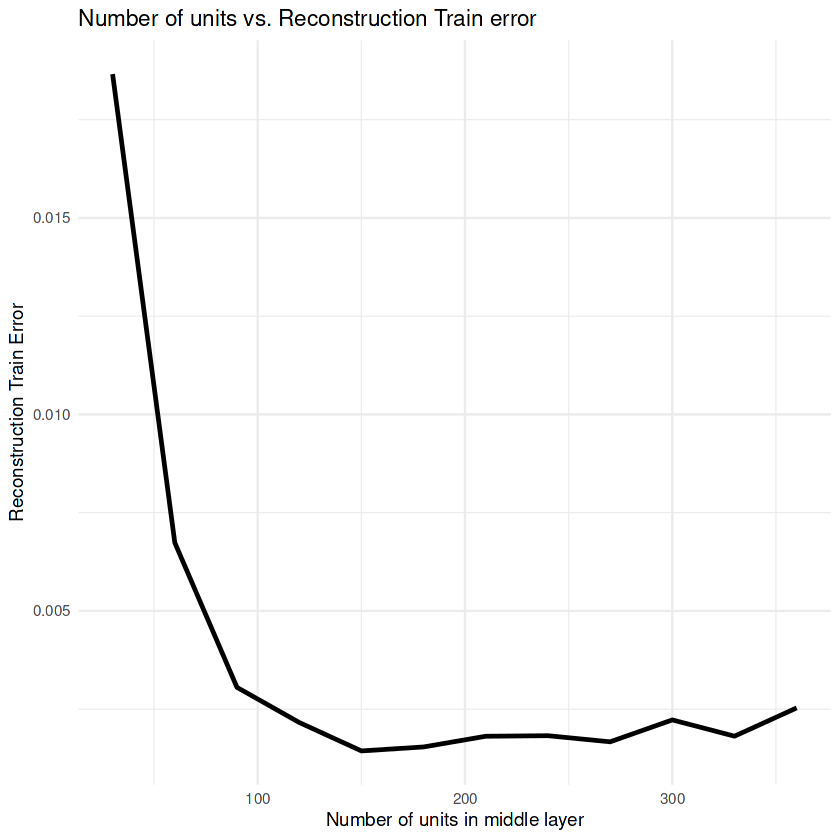

In [14]:
# Optional Code: Plotting the autoencoder train error for different number of neurons
ggplot(reconstruction.train.error, aes(x = N, y = train.error)) + geom_line(size = 1) + ggtitle("Number of units vs. Reconstruction Train error") + theme(plot.title = element_text(size = 15, hjust = 0.5))+
        xlab('Number of units in middle layer') + ylab('Reconstruction Train Error') + theme_minimal()

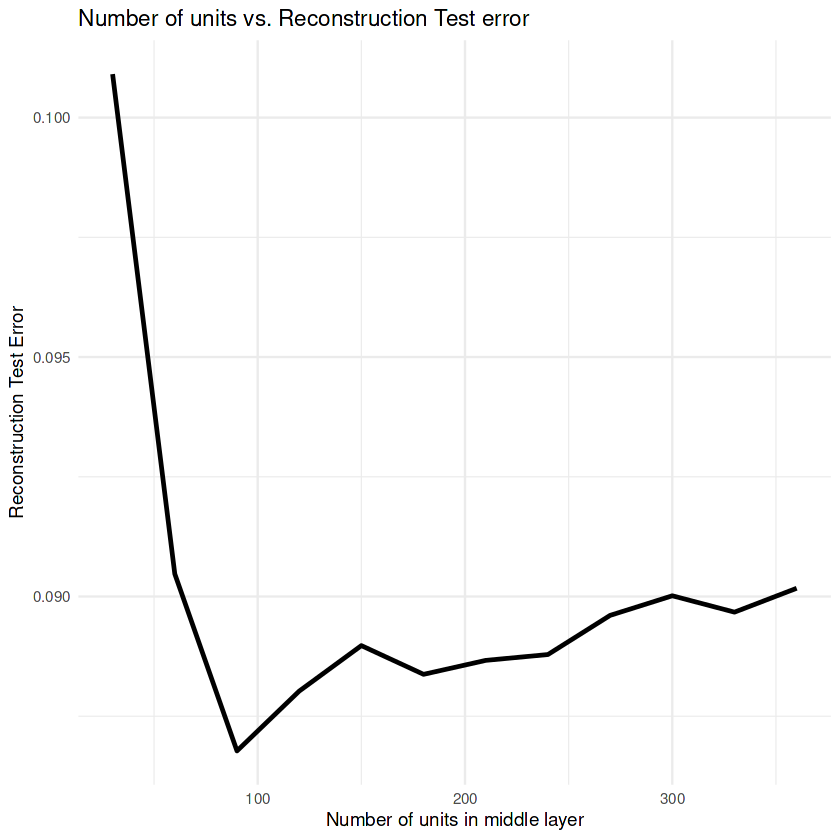

In [15]:
# Plotting the autoencoder test error for different number of neurons
ggplot(reconstruction.test.error, aes(x = N, y = test.error)) + geom_line(size=1) +
        ggtitle("Number of units vs. Reconstruction Test error") + theme(plot.title = element_text(size = 15, hjust = 0.5))+
        xlab('Number of units in middle layer') + ylab('Reconstruction Test Error') + theme_minimal()

Given the above plot, it can be observed that the reconstruction error for the autoencoder model is drastically reduced initially for an increasing number of units in the hidden layer before gradually increasing as the number of units increases. However, this may be a red herring as this drastic reduction in the error could also be a sign of overfitting on the part of some of the hidden units.

Nevertheless, if we were to drive a conclusion from the above graph, we can safely assume that the optimum number of units in the hidden layer is roughly somewhere between 100 and 200

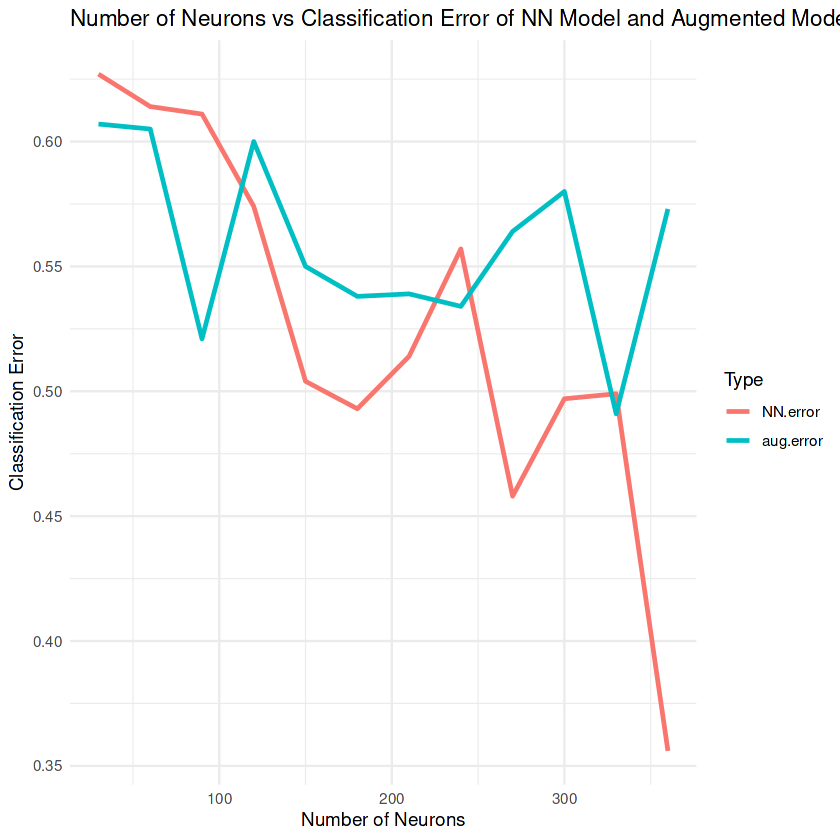

In [16]:
# Reshaping the classification error data for visualization
classification.test.error.m <- melt(classification.test.error, id = 'N')
names(classification.test.error.m) <- c('N', 'Type', 'test.error')

# Plotting the classification error for the augmented feature model and the neural network
ggplot(data = classification.test.error.m, aes(x = N, y = test.error, color = Type)) + geom_line(size = 1) +
        ggtitle("Number of Neurons vs Classification Error of NN Model and Augmented Model") +
        ylab("Classification Error") + xlab("Number of Neurons")  + theme_minimal()

Based on the comparative graph above, we can see that the classification test errors for the neural network and the augmented model decrease when the number of neurons or units in the hidden layer are increased. However, there are slight differences in the pattern of each error.

For example, the model that is trained with the augmented set of features performs better when the number of hidden units is less. Its test error is lower than that of the neural network for the smaller number of units. In contrast, the test error for the neural network decreases drastically for a larger number of units, especially after the 350 mark where it drops sharply. It significantly outperforms the augmented feature model. As discussed for the reconstruction error, a sharp decrease in neural network error may indicate overfitting of the training data by the neural network.

Therefore, we can conclude that out of the two models, the augmented model is better from a performance standpoint, with an optimum number of units that is not too large.

## References

* Badr, W. (2019, July 1). Auto-Encoder: What Is It? And What Is It Used For? (Part 1). Medium. https://towardsdatascience.com/auto-encoder-what-is-it-and-what-is-it-used-for-part-1-3e5c6f017726